# NLP - Kickstarter
From the point of view of investors, the risk of losing one's capital as a result of a failed investment is high for them.
Kickstarter's project have few risky characteristics for backers who want to invest in successful projects: 
- Items are frequently new and not evaluated in a mature market before.
- Creators may be unskilled and lack the necessary abilities to develop and launch products.

As a result, backers appears to be sort of Venture Capitalist. The only difference is that in this case, instead of equity, backers pledge money in exchange for a (usually tangible) reward. 

Therefore, taking the perspective of backers, we would only put money into initiatives that have the best chance of succeeding. Given the vast number of projects on Kickstarter, there would be plenty of high-probability-of-success campaigns to pick from.

With NLP, we will try to fit a model and evaluate its **precision**, since this appears to be the most relevant metric. "Out of the projects that the model predicted would be successes, how many turned out to be actual successes?"

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet 

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [3]:
# Create NLP dataset
dataset = pd.read_csv('Cleaned_Kickstarter.csv')
dataset = dataset[dataset.project_status != 'active']
dataset = dataset[dataset.state != 'live']
dataset1 = dataset[['project_id', 'name', 'slug', 'blurb', 'category', 'subcategory', 
                 'country', 'creation_to_launch_days', 'campaign_days', 'launch_day',
                  'deadline_day', 'launch_month', 'deadline_month','usd_goal', 'state']]

# not nation and city because 1292 null values
df_nlp = dataset1.copy()

<AxesSubplot:title={'center':'Frequency of Slug length'}>

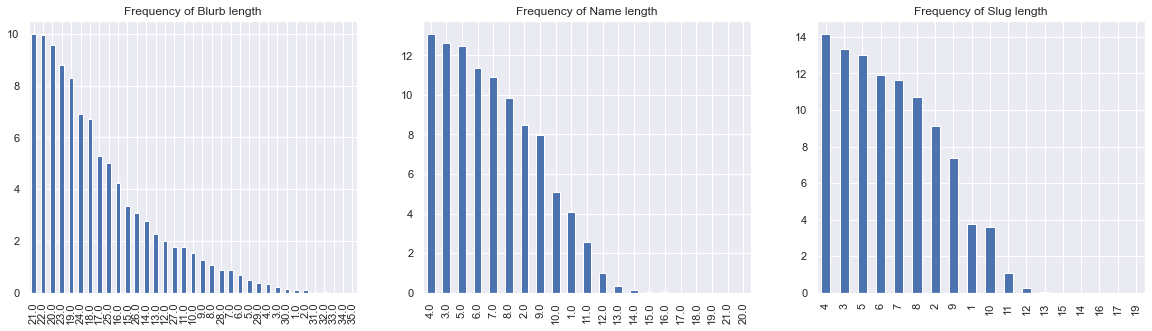

In [4]:
# Text variables length
df_nlp['name_len'] = df_nlp['name'].str.split().str.len()
df_nlp['slug_len'] = df_nlp['slug'].str.split("-").str.len()
df_nlp['blurb_len'] = df_nlp['blurb'].str.split().str.len()

# Frequencies
freq_name = df_nlp['name_len'].value_counts(normalize=True).mul(100)
freq_slug = df_nlp['slug_len'].value_counts(normalize=True).mul(100)
freq_blurb = df_nlp['blurb_len'].value_counts(normalize=True).mul(100)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
freq_blurb.plot(ax = axes[0], kind='bar', title = 'Frequency of Blurb length')
freq_name.plot(ax = axes[1], kind='bar', title = 'Frequency of Name length')
freq_slug.plot(ax = axes[2], kind='bar', title = 'Frequency of Slug length')

In [5]:
df_nlp[['name_len', 'slug_len', 'blurb_len']].describe()
df_nlp['state'].value_counts()

successful    78321
failed        74468
canceled       8532
suspended       616
Name: state, dtype: int64

On Average, the length of the name of a project is between 5 and 6 words. Same applies for the slug, which is the set of keywords suggested by the creator. As for blurbs, the average length is 20 words, even if it varies.

In [6]:
df_nlp[['name_len', 'slug_len', 'blurb_len', 'state']].groupby('state').count()
df_nlp[['name_len', 'slug_len', 'blurb_len', 'state']].describe()

,name_len,slug_len,blurb_len
count,161936.000000,161937.000000,161927.000000
mean,5.667869,5.398964,19.327950
std,2.722273,2.469670,4.927075
min,1.000000,1.000000,1.000000
25%,3.000000,3.000000,17.000000
50%,5.000000,5.000000,20.000000
75%,8.000000,7.000000,23.000000
max,21.000000,19.000000,35.000000


### PREPROCESSING STEPS
In the following code, we will preprocess the text variables: name, slug, blurb. 
We will clean the data following these steps:
- Lowercase 
- Remove extra whitespaces, punctuation special characters and numbers. Here, we assume that non-character words and numbers play a minimal role in prediction. 
- Expansion of the short form definitions
- Lemmatization of the words, to get them into their root words
- Remove Stop Words

In [7]:
# Contraction/Expansion of short words
contractions_dict = {
    'didn\'t': 'did not',
    'don\'t': 'do not',
    "aren't": "are not",
    "can't": "cannot",
    "cant": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "didnt": "did not",
    "doesn't": "does not",
    "doesnt": "does not",
    "don't": "do not",
    "dont" : "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i had",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'm": "i am",
    "im": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who's": "who is",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
    }


In [8]:
lemmatizer = WordNetLemmatizer()

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

# Normalize words
def normalize_document(d):
    d = str(d).lower() # lower case
    d = expand_contractions(d) #apply contraction-expansion function
    d = re.sub(r'[^a-zA-Z\s]', '', d, re.I|re.A) # substitute any character that is not a-z or A-Z and remove whitespaces
    d = d.strip()
    tokens = nltk.word_tokenize(d) # tokenize document
    words =[lemmatizer.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))] # lemmatization
    d = ' '.join(words) 
    return d

df_nlp['blurb_clean'] = df_nlp['blurb'].apply(normalize_document)
df_nlp['name_clean'] = df_nlp['name'].apply(normalize_document)
df_nlp['slug_clean'] = df_nlp['slug'].str.replace("-", " ").apply(normalize_document) 

# Combine text variables
df_nlp['combined_text'] = df_nlp['blurb_clean'] + df_nlp['slug_clean'] + df_nlp['name_clean']

In [9]:
df_nlp.dtypes

project_id                   int64
name                        object
slug                        object
blurb                       object
category                    object
subcategory                 object
country                     object
creation_to_launch_days      int64
campaign_days                int64
launch_day                  object
deadline_day                object
launch_month                object
deadline_month              object
usd_goal                   float64
state                       object
name_len                   float64
slug_len                     int64
blurb_len                  float64
blurb_clean                 object
name_clean                  object
slug_clean                  object
combined_text               object
dtype: object

In [10]:
df_nlp.head()

,project_id,name,slug,blurb,category,subcategory,country,creation_to_launch_days,campaign_days,launch_day,...,deadline_month,usd_goal,state,name_len,slug_len,blurb_len,blurb_clean,name_clean,slug_clean,combined_text
1,860485,Zone 7 Street Arts Initiative,zone-7-street-arts-initiative,Be a part of Street Art Magic and have a hand ...,art,Public Art,US,7,14,Thursday,...,February,777.0,failed,5.0,5,23.0,part street art magic hand creating piece visu...,zone street art initiative,zone street art initiative,part street art magic hand creating piece visu...
2,1102377,Loving Becca ~ Journey of Child Loss,loving-becca-journey-of-child-loss,My writing changed after my daughter was kille...,journalism,Print,US,5,30,Friday,...,August,1000.0,successful,7.0,6,26.0,writing changed daughter killed drunk driver w...,loving becca journey child loss,loving becca journey child loss,writing changed daughter killed drunk driver w...
3,2531031,Sweet Botanist Syrups for baristas & cocktail ...,the-sweet-botanist-syrup-co,The Sweet Botanist's natural syrups are made s...,food,Drinks,US,0,30,Wednesday,...,June,1000.0,failed,8.0,5,19.0,sweet botanist natural syrup made small batch ...,sweet botanist syrup baristas cocktail maker,sweet botanist syrup co,sweet botanist natural syrup made small batch ...
4,95060,El Capitan Film Restoration,el-capitan-film-restoration,The digital restoration of the classic 1968 Ro...,film & video,Documentary,US,209,30,Tuesday,...,November,25000.0,successful,4.0,4,12.0,digital restoration classic rock cli ambing fi...,el capitan film restoration,el capitan film restoration,digital restoration classic rock cli ambing fi...
5,1769096,Urban Emojis,urban-emojis,New emojis that feature emoticons for various ...,technology,Apps,US,5,30,Thursday,...,April,50000.0,failed,2.0,2,22.0,new emojis feature emoticon various race gende...,urban emojis,urban emojis,new emojis feature emoticon various race gende...


### Word Cloud

In [9]:
vect = CountVectorizer(max_features=10000)
X = vect.fit_transform(df_nlp['combined_text'].values)

In [10]:
word_cnts = np.asarray(X.sum(axis=0)).ravel().tolist()  # for each word in column, sum all row counts
feature_names = vect.get_feature_names()
word_counts = pd.DataFrame({'word': feature_names, 'count': word_cnts})
word_freq = pd.Series(word_counts['count'])
word_freq.index = word_counts ['word']
text_freq = word_freq.to_dict()
word_counts.sort_values('count', ascending=False)[:20]

,word,count
6079,new,26366
4305,help,19310
628,art,16138
193,album,16098
5960,music,13958
1156,book,13947
7041,project,13419
3518,film,12903
3557,first,12571
5459,make,11244


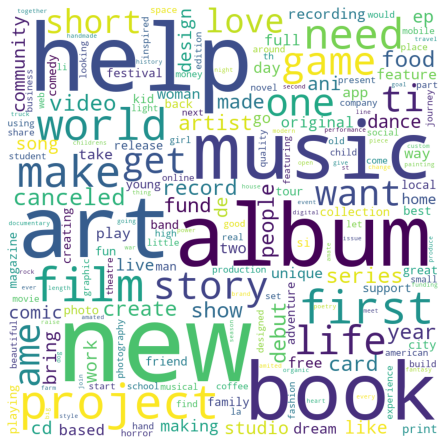

In [11]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=800, max_font_size=200, background_color="white").generate_from_frequencies(text_freq)
                    
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

### Topic Modeling and Document Clustering
https://towardsdatascience.com/exploring-textual-data-using-lda-ef1f53c772a4

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)

document_topics = lda.fit_transform(X)

In [ ]:
print("lda.components_.shape: {}".format(lda.components_.shape)) #(n_topics, n_words)

In [ ]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, X, vect)

### **Model 1**: Logistic Regression considering only text and output


In [11]:
# Bag of Words

values = ['canceled', 'suspended']

df_nlp = df_nlp[df_nlp.state.isin(values) == False]

X = df_nlp['combined_text'].values
y = df_nlp["state"].replace({'failed' : 0, 'successful': 1})

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True, random_state=123)


cv = CountVectorizer()
cv_train_features = cv.fit_transform(X_train)

cv_test_features = cv.transform(X_test)

print('Bag of Words model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)
lr.fit(cv_train_features, y_train)


lr_bow_predictions = lr.predict(cv_test_features)

print(classification_report(y_test, lr_bow_predictions))

Bag of Words model:> Train features shape: (122231, 313394)  Test features shape: (30558, 313394)
              precision    recall  f1-score   support

           0       0.68      0.68      0.68     14895
           1       0.70      0.69      0.69     15663

    accuracy                           0.69     30558
   macro avg       0.69      0.69      0.69     30558
weighted avg       0.69      0.69      0.69     30558



In [12]:
# Tfid
tv = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(X_train)


tv_test_features = tv.transform(X_test)

print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)


lr.fit(tv_train_features, y_train)


lr_tfidf_predictions = lr.predict(tv_test_features)

print(classification_report(y_test, lr_tfidf_predictions))

TFIDF model:> Train features shape: (122231, 45558)  Test features shape: (30558, 45558)
              precision    recall  f1-score   support

           0       0.70      0.69      0.69     14895
           1       0.71      0.72      0.71     15663

    accuracy                           0.70     30558
   macro avg       0.70      0.70      0.70     30558
weighted avg       0.70      0.70      0.70     30558



Tfid performs better than Bag of Words
(The f-score and precision are good but not enough, potentially indicates that we may not have the volume of data or number of attributes needed in order to make robust predictions.)

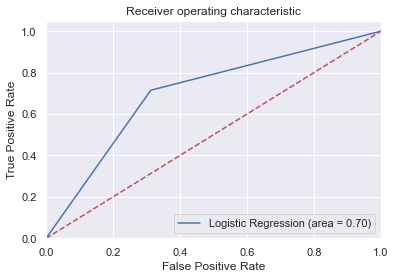

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, lr_tfidf_predictions)
fpr, tpr, thresholds = roc_curve(y_test, lr_tfidf_predictions)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [14]:
vect = CountVectorizer().fit(X_train)
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Number of features: 313394


In [ ]:
vect1 = CountVectorizer(min_df=5).fit(X_train)
feature_names1 = vect1.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("Ratio number of features: ",len(feature_names1)/len(feature_names)*100, "%")

By requiring at least five appearances of each token, we can bring down the number of features to 18295, as seen in the preceding output. Less than 6% of the original amount features.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(solver='liblinear'))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

In [ ]:
# Compress with SVD
from sklearn.decomposition import TruncatedSVD
# For LSA, a value of 100 is recommended
svd = TruncatedSVD(n_components=100)
latent_matrix = svd.fit_transform(cvect_df)

### Model 2: Logistic regression considering more variables

In [ ]:
from sklearn import set_config 

numeric_features =['usd_goal','campaign_days','creation_to_launch_days']
numeric_transformer = Pipeline(steps =[
    ("imputer",SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())])

#Encode categorical features
cat_features=['category','subcategory', 'country']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

text_feature = ['combined_text']
#text_transformer = TfidfVectorizer(norm=None)
text_transformer = Pipeline(steps =[
    ("counter",TfidfVectorizer()),
    ("scaler", OneHotEncoder())])
    
#Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, cat_features),
        ("text",text_transformer, text_feature)])

set_config(display="diagram")

y = df_nlp["state"].replace({'failed' : 0, 'successful': 1})
X = df_nlp[['usd_goal','campaign_days','creation_to_launch_days', 
            'launch_month', 'deadline_month', 'category','subcategory', 
            'country', 'combined_text']]


#X_trans = preprocessor.fit_transform(X)

#X_train, X_test, y_train, y_test = train_test_split(X_trans,y,test_size=0.2,shuffle=True, random_state=123)

#Build Logistic Regression
#clf = LogisticRegression()
#clf.fit(X_train, y_train)

# Making predictions
#y_train_pred = clf.predict(X_train)
#y_test_pred = clf.predict(X_test)

### TruncateSVD

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectors= vectorizer.fit_transform(df_nlp ['combined_text'])

#cvect_df = pd.DataFrame(meta_vectors.toarray(), index=df_nlp.index.tolist())
#print(cvect_df.shape)

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50)
latent_matrix = svd.fit_transform(cvect_df)

latent_matrix_1 = pd.DataFrame(latent_matrix[:,0:50], index=df_merged.title.tolist())

In [ ]:
# Bag of Words

values = ['canceled', 'suspended']

df_nlp = df_nlp[df_nlp.state.isin(values) == False]

X = df_nlp['combined_text'].values
y = df_nlp["state"].replace({'failed' : 0, 'successful': 1})

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True, random_state=123)


cv = CountVectorizer()
cv_train_features = cv.fit_transform(X_train)

cv_test_features = cv.transform(X_test)

print('Bag of Words model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)
lr.fit(cv_train_features, y_train)


lr_bow_predictions = lr.predict(cv_test_features)

print(classification_report(y_test, lr_bow_predictions))

In [ ]:
# Another 

values = ['canceled', 'suspended']

df_nlp = df_nlp[df_nlp.state.isin(values) == False]

X = df_nlp['combined_text'].values
y = df_nlp["state"].replace({'failed' : 0, 'successful': 1})

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True, random_state=123)



tf_idf_vect = TfidfVectorizer(ngram_range=(1,1), min_df=10,use_idf= True)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
final_tf_idf = tf_idf_vect.transform(X_train)

In [ ]:
cooccurrenceMatrix = np.zeros((6000,6000)) # co-occurance matrix
context_window = 4 # context window for co-occurance matrix

In [ ]:
for sent in tqdm(df_nlp['combined_text']):
    words_sent = sent.split()
    for index, word in enumerate(words_sent):
        if word in top_6000_feat_names:
            for j in range(max(index-context_window,0),min(index+context_window, len(words_sent)-1)+1):
                if words_sent[j] in top_6000_feat_names_feat_names:
                    if words_sent[j] != word:
                        cooccurrenceMatrix[Top_2000.index(words_sent[j]), Top_2000.index(word)] += 1
                    else:
                        pass
                else:
                    pass
        else:
            pass
        

In [ ]:
# Program to find the optimal number of components for Truncated SVD
n_comp = [4,10,15,20,50,100,150,200,500,700,800,900,1000,1500,2000,2500,3000,3500] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(cooccurrenceMatrix)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()